# Part 1: Fully Connected Layers

Daniel-Alexandru Bejan (474404)
Patrick Schaper (534366)

The provided dataset contains possible combinations for the game Yathzee. If you don’t know the rules for this dice game, please have a look at: https://en.wikipedia.org/wiki/Yahtzee.

Please note: the dataset is imbalanced. This means that you might need to balance it first
before you will get good results! There a several possible solutions, please read: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758 for a better understanding.

You will need to build a neural network that is able to predict the label for 5 thrown dice. The available labels are mentioned in the table below.

- 3-of-a-kind: Three dice the same.
- 4-of-a-kind: Four dice the same.
- Full-house: Three of one number and two of another
- small-straight Four sequential dice: (1-2-3-4, 2-3-4-5, or 3-4-5-6)
- Large-straight Five sequential dice: (1-2-3-4-5 or 2-3-4-5-6)
- Yathzee: All five dice the same
- Nothing: None of the above combinations has been thrown

**Goal of the assignment**

The overall goal is to experiment with deep learning and find out what gives you the
best results. Don’t forget to compare the results and write a conclusion!
Experiments we expect you to carry out:
- Playing around with different networks sizes
 - Different number of layers
 - Different number of neurons per layer
 - At least 6 different networks with a minimum of 1 hidden layer per network
- Comparison of different activation functions:
 - Sigmoid
 - Tanh
 - ReLu
- Difference with and without dropout.

The notebook should contain:
- For each neural network that you train: graphs from TensorBoard or Matplotlib showing the accuracy and the loss for train set and validation set and the accuracy scores for the test set.
- Your observations and conclusions per network (and graph)!
- An export of your best trained network and a way to run this exported model.

**Hints**

In order to build proper neural networks, keep in mind:
- Convert the labels into one-hot-encoded values.
- Use cross-entropy as loss function for classification.
- Create a proper output layer that uses SoftMax activation.
- Use the accuracy metric to measure your classification performance.
- Avoid overfitting by using dropout, a test set (which you use in the end) and cross validation.

Export your best model and add a cell to your notebook that loads the model and is
able to validate your model, by loading in a dataset from file and feeding it into the
network. This cell should show the accuracy of the classifier.


## Load the Data

In [1]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('MLBD-dataset-yahtzee.csv')
raw_df.head() 

,dice1,dice2,dice3,dice4,dice5,label
0,3,6,6,2,5,nothing
1,3,6,1,3,4,nothing
2,2,2,5,5,3,nothing
3,1,3,6,6,1,nothing
4,1,4,6,3,5,small-straight


## Analyse the Data

In [2]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832 entries, 0 to 5831
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dice1   5832 non-null   int64 
 1   dice2   5832 non-null   int64 
 2   dice3   5832 non-null   int64 
 3   dice4   5832 non-null   int64 
 4   dice5   5832 non-null   int64 
 5   label   5832 non-null   object
dtypes: int64(5), object(1)
memory usage: 273.5+ KB


We see that there are no null values and all data sets are therefore complete

### How balanced is our data set?

In [3]:
count_values = raw_df.groupby(['label'])['label'].count()
count_values

label
four-of-a-kind      116
full-house          221
large-straight      178
nothing            3868
small-straight      549
three-of-a-kind     896
yathzee               4
Name: label, dtype: int64

### Result of analysing

We see a very unbalanced data set. One rubric stands out particularly strongly. The number of "yathzee's" is just 4. According to the rules of the game, a "yathzee" occurs when all dice show the same number. So we add the missing records.

In [4]:
raw_df[raw_df['label'] == 'yathzee']

,dice1,dice2,dice3,dice4,dice5,label
1101,5,5,5,5,5,yathzee
1180,2,2,2,2,2,yathzee
1602,6,6,6,6,6,yathzee
5504,3,3,3,3,3,yathzee


In [5]:
df = raw_df.copy()

df.loc[len(df.index)] = [1,1,1,1,1,'yathzee']
df.loc[len(df.index)] = [4,4,4,4,4,'yathzee']

## Extract the data

How to split the dataset into Features=X and Target=Y. We also convert the strings in our target column to numbers, since a model works better with numbers. Also the one-hot encoding is in this step.

Class=0, n=3868 (66.301%)
Class=1, n=549 (9.410%)
Class=2, n=896 (15.358%)
Class=3, n=178 (3.051%)
Class=4, n=221 (3.788%)
Class=5, n=116 (1.988%)
Class=6, n=6 (0.103%)


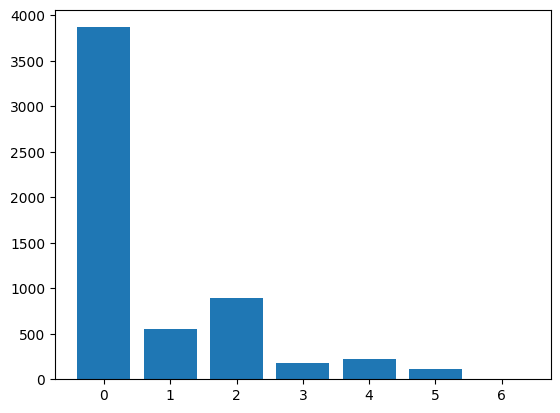

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df_for_this_cell = df #bal_df

y_labels = df_for_this_cell.label.unique()
df.label = pd.factorize(df.label)[0]

features = []
for feature in df_for_this_cell.columns:
    if feature != 'label':
        features.append(feature)
        
X = df_for_this_cell[features]
y = df_for_this_cell['label']

y_encoded = LabelEncoder().fit_transform(y)

counter = Counter(y_encoded)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
plt.bar(counter.keys(), counter.values())
plt.show()

## Cross validation - split the dataset

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Normalize the data - keras loves to work with numbers between 0 and 1

In [8]:
import tensorflow as tf
from tensorflow import keras

def normalize_for_keras(data):
    return tf.keras.utils.normalize(data, axis=1)

X_train_raw = X_train
X_test_raw = X_test
X_train = normalize_for_keras(X_train)
X_test =  normalize_for_keras(X_test)

2023-01-30 02:59:07.384682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3101,  425,  721,  146,  173,   97,    4]))

In [10]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([767, 124, 175,  32,  48,  19,   2]))

## Balancing the data

In order to train our model better, we balance our data set. To avoid overfitting we do this after splitting the data into training and test data. Although the values are then somewhat worse (we have done several tests), our model is more robust this way.

We first determine the median of the number of different classes. Then we apply undersampling to all classes that are above the median. For all data below the median we use oversampling.

In [11]:
train_n_samples = int(round(np.unique(y_train, return_counts=True)[1].mean()))
test_n_samples = int(round(np.unique(y_test, return_counts=True)[1].mean()))
print(train_n_samples)
print(test_n_samples)

667
167


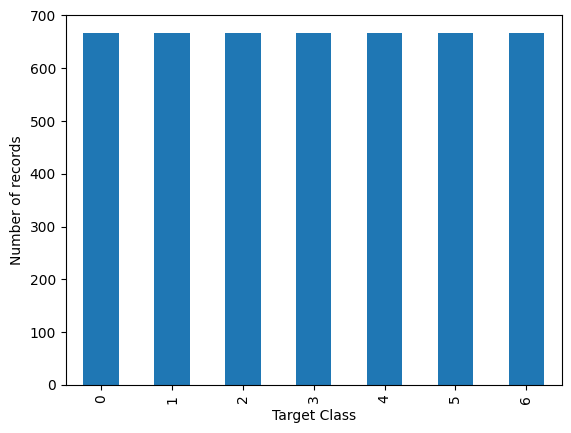

In [12]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE

def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train, y_train, train_n_samples, t='majority'))
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_train_under, y_train_under, train_n_samples, t='minority'), k_neighbors=3)

X_train_bal, y_train_bal = over_sampler.fit_resample(X_train_under, y_train_under)

count = y_train_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

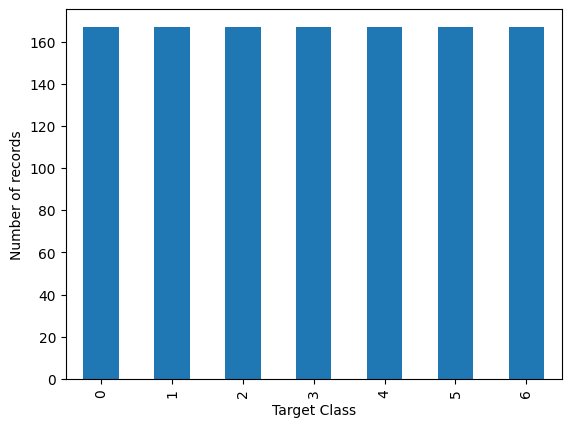

In [13]:
under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_test, y_test, test_n_samples, t='majority'))
X_test_under, y_test_under = under_sampler.fit_resample(X_test, y_test)

over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_test_under, y_test_under, test_n_samples, t='minority'), k_neighbors=1)

X_test_bal, y_test_bal = over_sampler.fit_resample(X_test_under, y_test_under)

count = y_test_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

## Load the important libarys

In [14]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Nadam
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Normalization
from tensorflow.keras.callbacks import History, TensorBoard
from sklearn.utils import class_weight

### Normalize X values for keras

In [15]:
normalizer = keras.layers.Normalization()
normalizer.adapt(X_train_bal)
normalizer.adapt(X_test_bal)

2023-01-30 02:59:14.762650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define methods for evaluate, create and fill a model

In [16]:
def evaluat_my_model(model, input_data, output_data):
    
    output_data = output_data.values.reshape(-1,1)
    output_data = tf.keras.utils.to_categorical(output_data, np.unique(output_data).size)
    
    evaluation_results = model.evaluate(input_data, output_data)

    return evaluation_results

In [17]:
# variable to save all the params for each model in this notebook
models = []

# Valid command to create a model with 2 hidden layers and 1 dropout layer:
# model = create_mode(X, y, [(300,"relu"),(210,"relu",0.2)] )
# 
# After every hidden layer will be add a normalize layer
#
# The loss function is the categorical_crossentropy from keras for multi category
#
def create_model(input_data, output_data, layers=[], optimizer="adam", endActi="softmax", learningRate = 0.0001):
    
    inputNeurons = input_data.shape[1]
    outputNeurons = np.unique(output_data).size
    
    model = Sequential()
    
    firstLayer = True
    
    for layer in layers:
        if(firstLayer):
            model.add(Dense(layer[0], input_shape=(inputNeurons,), activation=layer[1]))
            firstLayer = False
        else:
            model.add(Dense(layer[0], activation=layer[1]))
            
        model.add(BatchNormalization())
        
        if(2 < len(layer)):
            model.add(Dropout(layer[2]))
    
    model.add(Dense(outputNeurons, activation=endActi))
    
    if optimizer == "adam":
        opti = Adam(learning_rate=learningRate)
    elif optimizer == "nadam":
        opti = Nadam(learning_rate=learningRate)
    elif optimizer == "sgd":
        opti = SGD(learning_rate=learningRate)
    elif optimizer == "adagrad":
        opti = Adagrad(learning_rate=learningRate)
    else:
        opti = optimizer
    
    model.compile(loss="categorical_crossentropy", optimizer=opti, metrics=["accuracy"])
    
    return model

def create_fit_model(input_data, output_data, layers=[], optimizer="adam", endActi="softmax", learningRate=0.0001, batchSize=128, epochs=250, verbose=0, withHistory=0):
        
        model = create_model(input_data, output_data, layers, optimizer=optimizer, endActi=endActi, learningRate=learningRate)
        
        inputNeurons = input_data.shape[1]
        outputNeurons = np.unique(output_data).size

        # The output classes will transform to categorical
        output_data = output_data.values.reshape(-1,1)
        output_data = tf.keras.utils.to_categorical(output_data, outputNeurons)
        y_test_cat = tf.keras.utils.to_categorical(y_test_bal, outputNeurons)
        
        history = History()
        history = model.fit(x=input_data, y=output_data, batch_size=batchSize, epochs=epochs, verbose=verbose, shuffle=True, validation_split=0.2, callbacks=[history])
        evaluate = evaluat_my_model(model=model, input_data=X_test_bal, output_data=y_test_bal)
        models.append({
            'layers':layers,
            'optimizer':optimizer,
            'batchSize':batchSize,
            'learningRate':learningRate,
            'epochs':epochs,
            'endActi':endActi,
            'best_loss':evaluate[0],
            'best_accuracy':evaluate[1],
            'loss':history.history['loss'],
            'accuracy':history.history['accuracy'],
            'val_accuracy':history.history['val_accuracy']
            })
        
        if withHistory == 1:
            return model, history
        return model

def plot_acc_loss(history):
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

## Create different Models

At this point it should be mentioned that we have performed this step very often. In order to fulfill the individual tasks, the various parameters are set.

The models default create all with adam optimizer and softmax as proper output function, BatchSize is 128 and epochs 250. Also after every layer, not the last layer, comes a BatchNormalization layer.

example:

(300,"relu") - one hidden layer with 300 output neurons with relu activation
(210, 'sigmoid', 0.2) - one hidden layer with 210 output neurons with sigmoid activation and after 0.2 Dropout

neuron test:
- (10,"relu")
- (100,"relu")
- (1000,"relu")
- (10000,"relu")

activation function test:
- (5000,"relu")
- (5000,"tanh")
- (5000,"sigmoid")

more layer (random):

- (1000,"relu"), (2000,"relu")
- (1000,"relu"), (2000,"relu"), (1000,"relu"), (2000,"relu")
- (5000,"relu"), (3000,"relu"), (1000,"relu"), (500,"relu")
- (1000,"relu"), (2000,"tanh")
- (1000,"relu"), (2000,"tanh"), (1000,"relu"), (2000,"relu")
- (5000,"relu"), (3000,"relu"), (1000,"tanh"), (500,"relu")
- (1000,"relu"), (2000,"sigmoid")
- (1000,"relu"), (2000,"sigmoid"), (1000,"relu"), (2000,"relu")
- (5000,"relu"), (3000,"relu"), (1000,"sigmoid"), (500,"relu")

same layer like before with random fix dropout:

- (1000,"relu"), (2000,"relu", 0.2)
- (1000,"relu"), (2000,"relu", 0.2), (1000,"relu", 0.1), (2000,"relu")
- (5000,"relu"), (3000,"relu", 0.3), (1000,"relu", 0.25), (500,"relu")
- (1000,"relu"), (2000,"tanh", 0.2)
- (1000,"relu"), (2000,"tanh", 0.2), (1000,"relu", 0.1), (2000,"relu")
- (5000,"relu"), (3000,"relu", 0.3), (1000,"tanh", 0.25), (500,"relu")
- (1000,"relu"), (2000,"sigmoid", 0.2)
- (1000,"relu"), (2000,"sigmoid", 0.2), (1000,"relu", 0.1), (2000,"relu")
- (5000,"relu"), (3000,"relu", 0.3), (1000,"sigmoid", 0.25), (500,"relu")

random models:

- (300,"relu"), (210,"sigmoid"), (130,"relu"), (80,"relu")

37/37 [==============================] - 0s 509us/step - loss: 2.2117 - accuracy: 0.1788


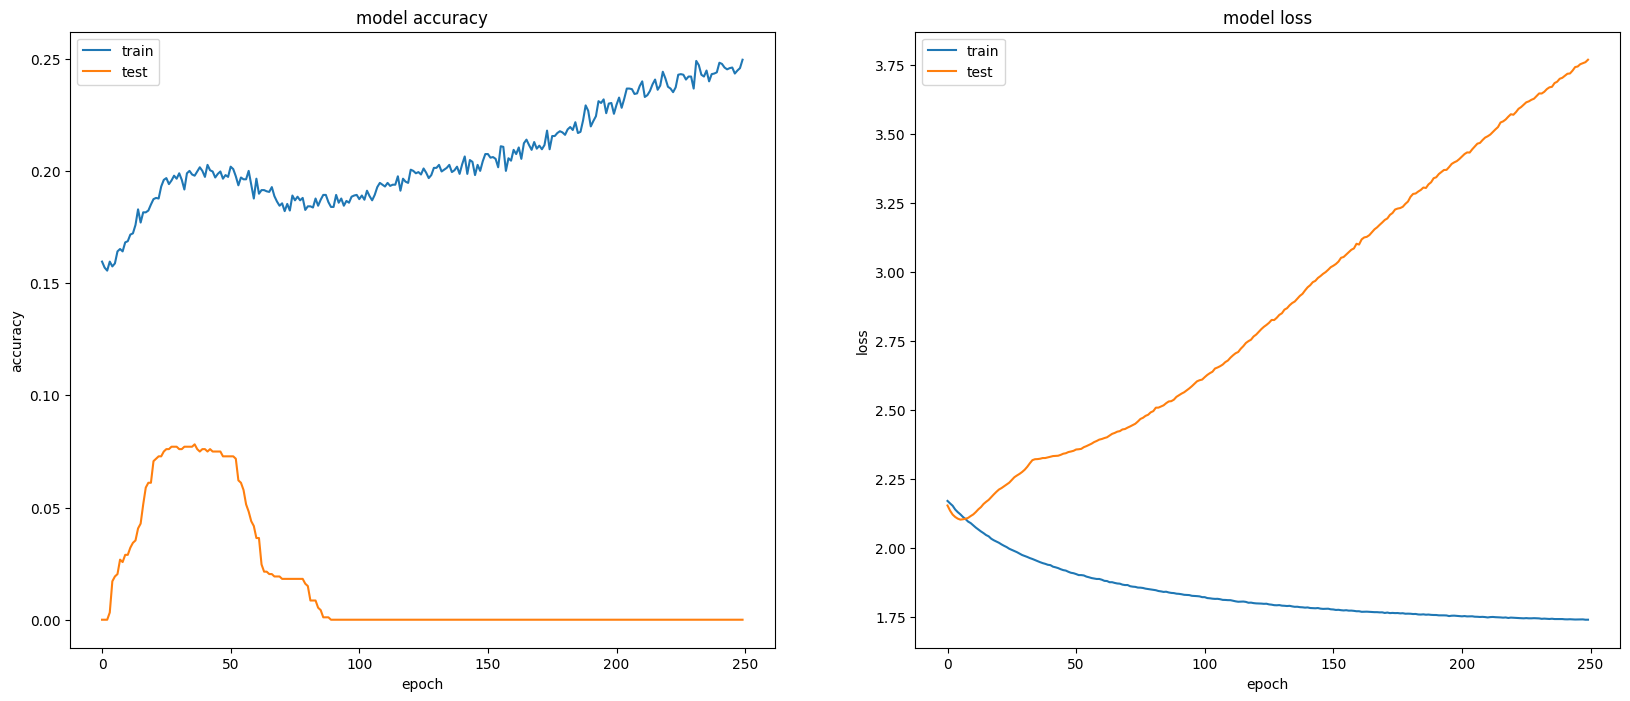

In [18]:
layers = [(10,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 531us/step - loss: 2.2269 - accuracy: 0.2575


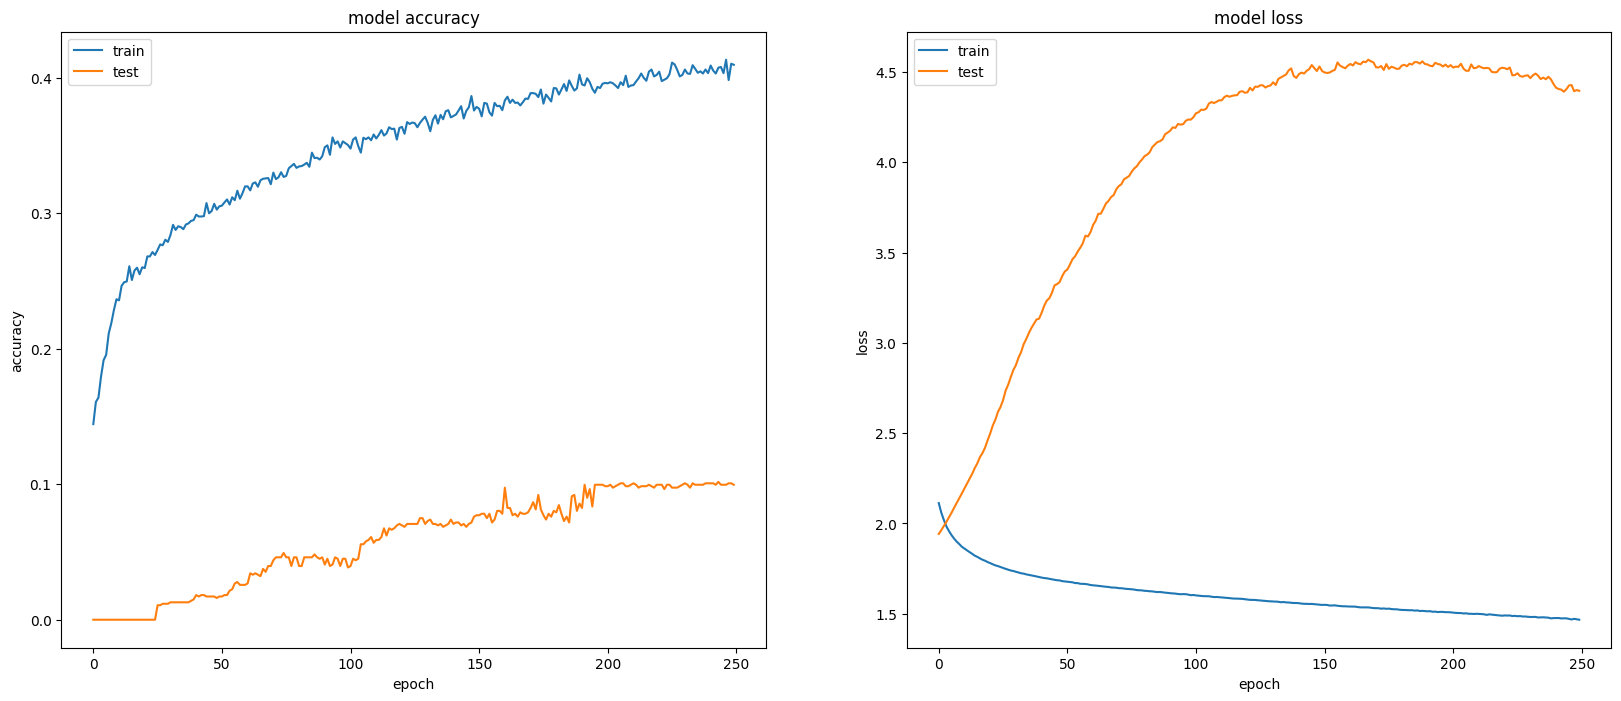

In [19]:
layers = [(100,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 586us/step - loss: 1.5521 - accuracy: 0.3944


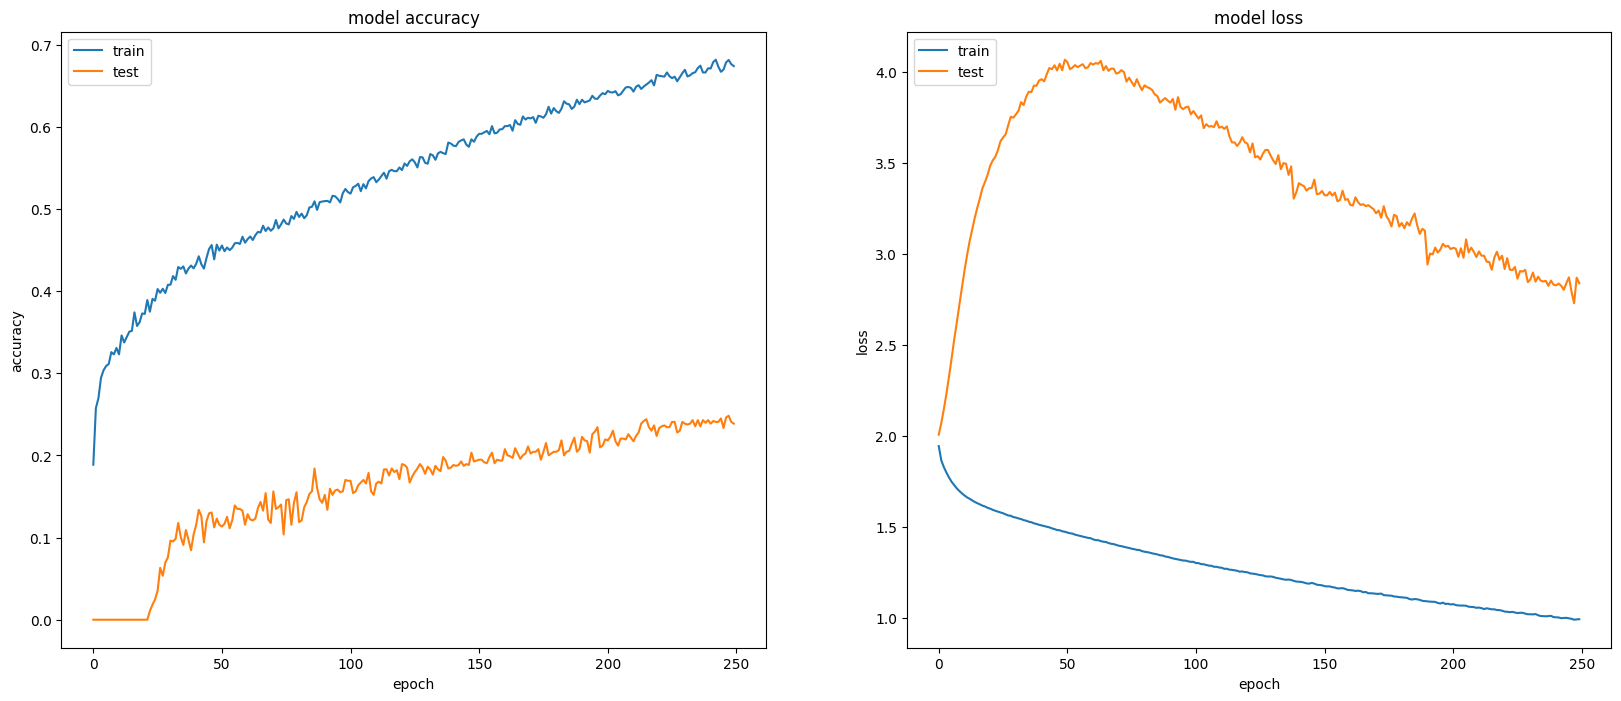

In [20]:
layers = [(1000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 1ms/step - loss: 0.8703 - accuracy: 0.5851


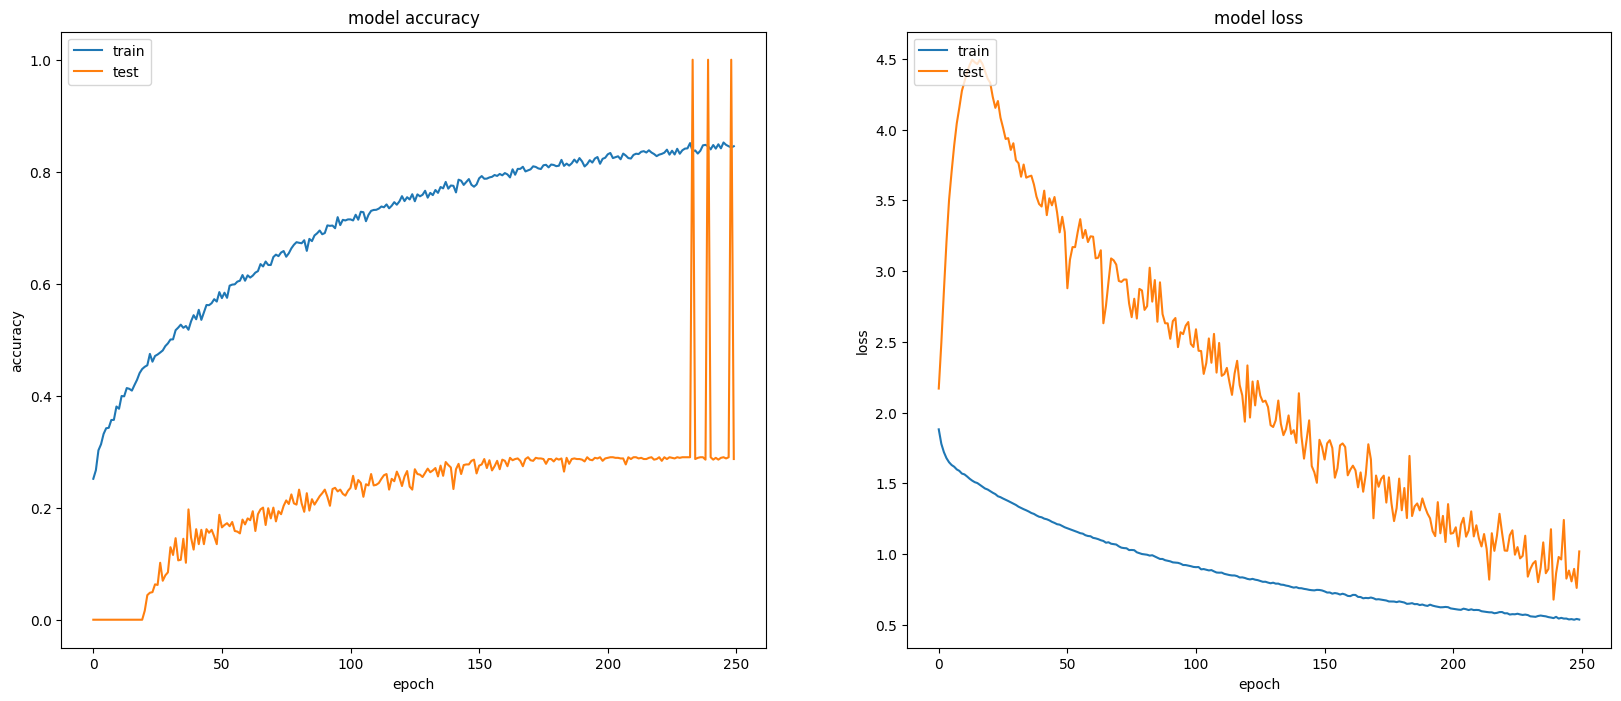

In [21]:
layers = [(10000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

#### activation function tests

37/37 [==============================] - 0s 929us/step - loss: 1.0408 - accuracy: 0.5338


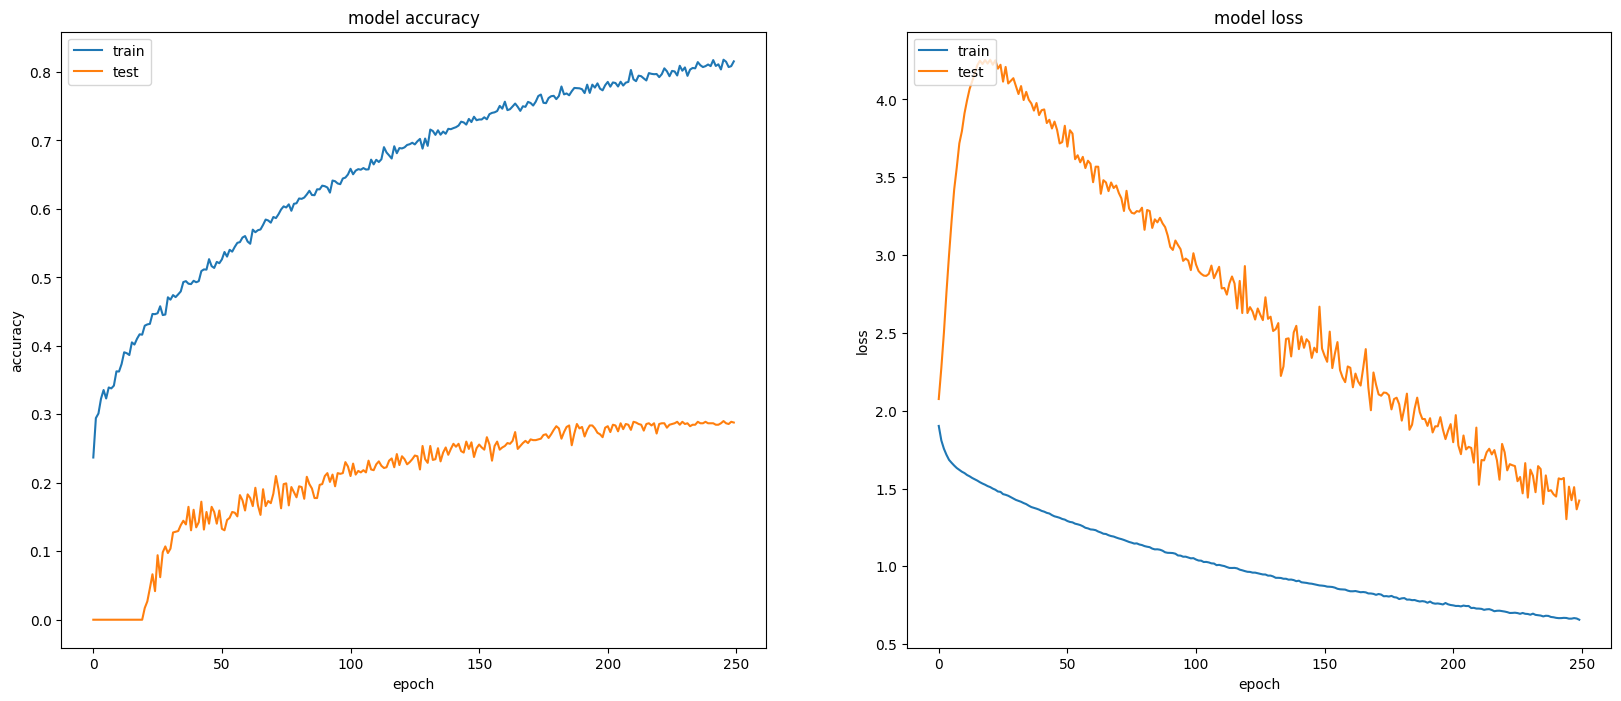

In [22]:
layers = [(5000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 1ms/step - loss: 2.2620 - accuracy: 0.2019


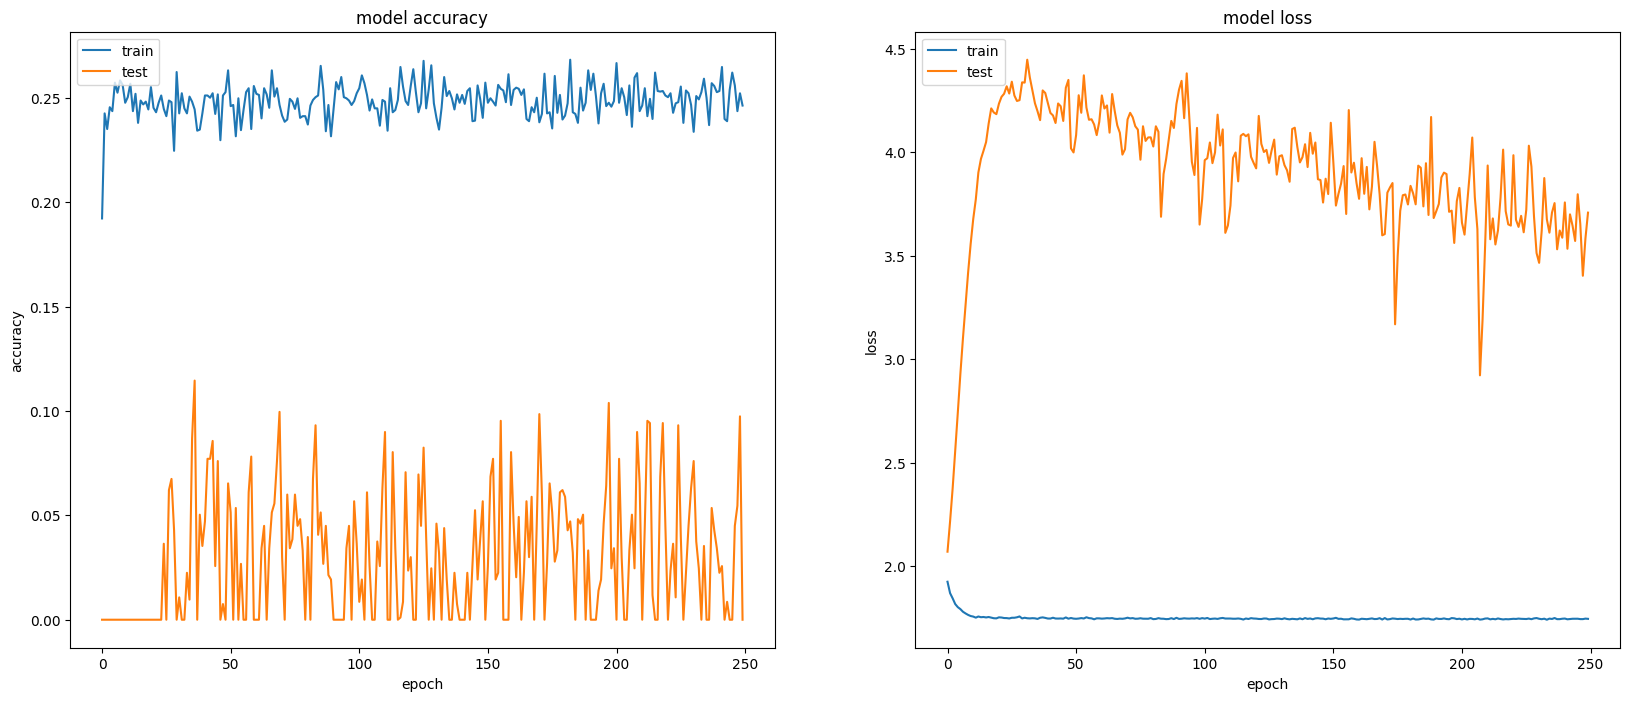

In [23]:
layers = [(5000,"tanh")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 1ms/step - loss: 2.3247 - accuracy: 0.1967


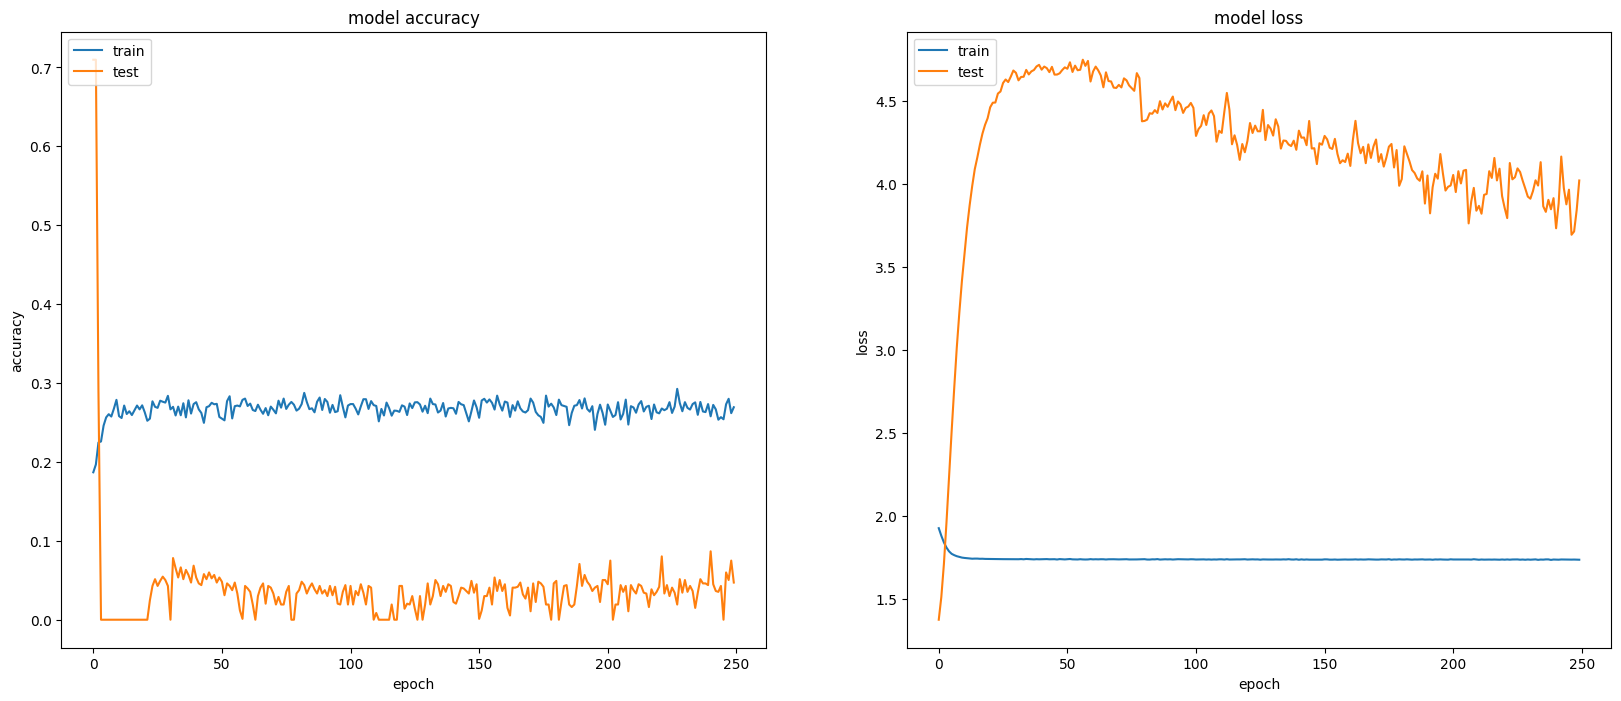

In [24]:
layers = [(5000,"sigmoid")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

#### more layer (random)

37/37 [==============================] - 0s 2ms/step - loss: 0.9806 - accuracy: 0.7066


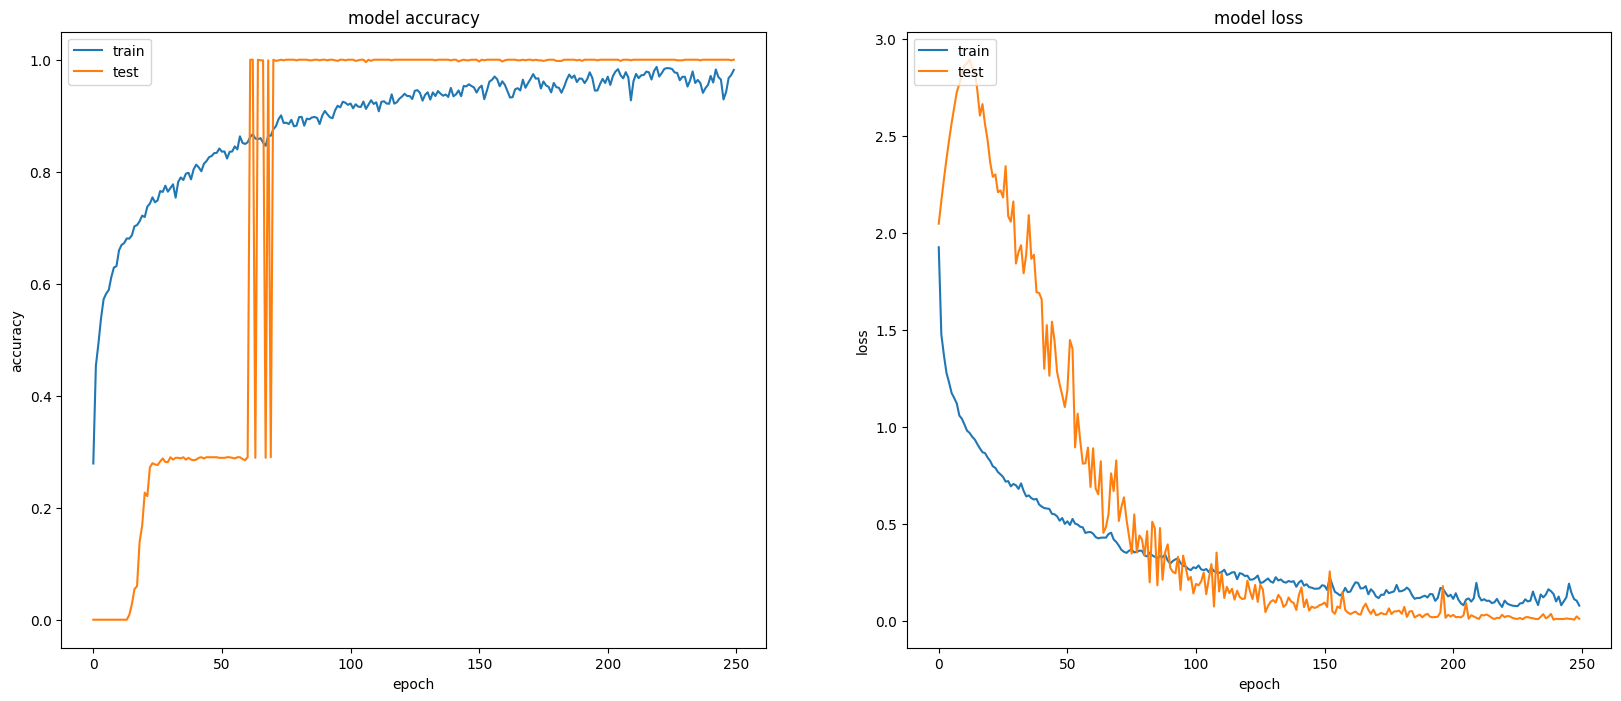

In [25]:
layers = [(1000,"relu"), (2000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 7ms/step - loss: 1.3984 - accuracy: 0.7023


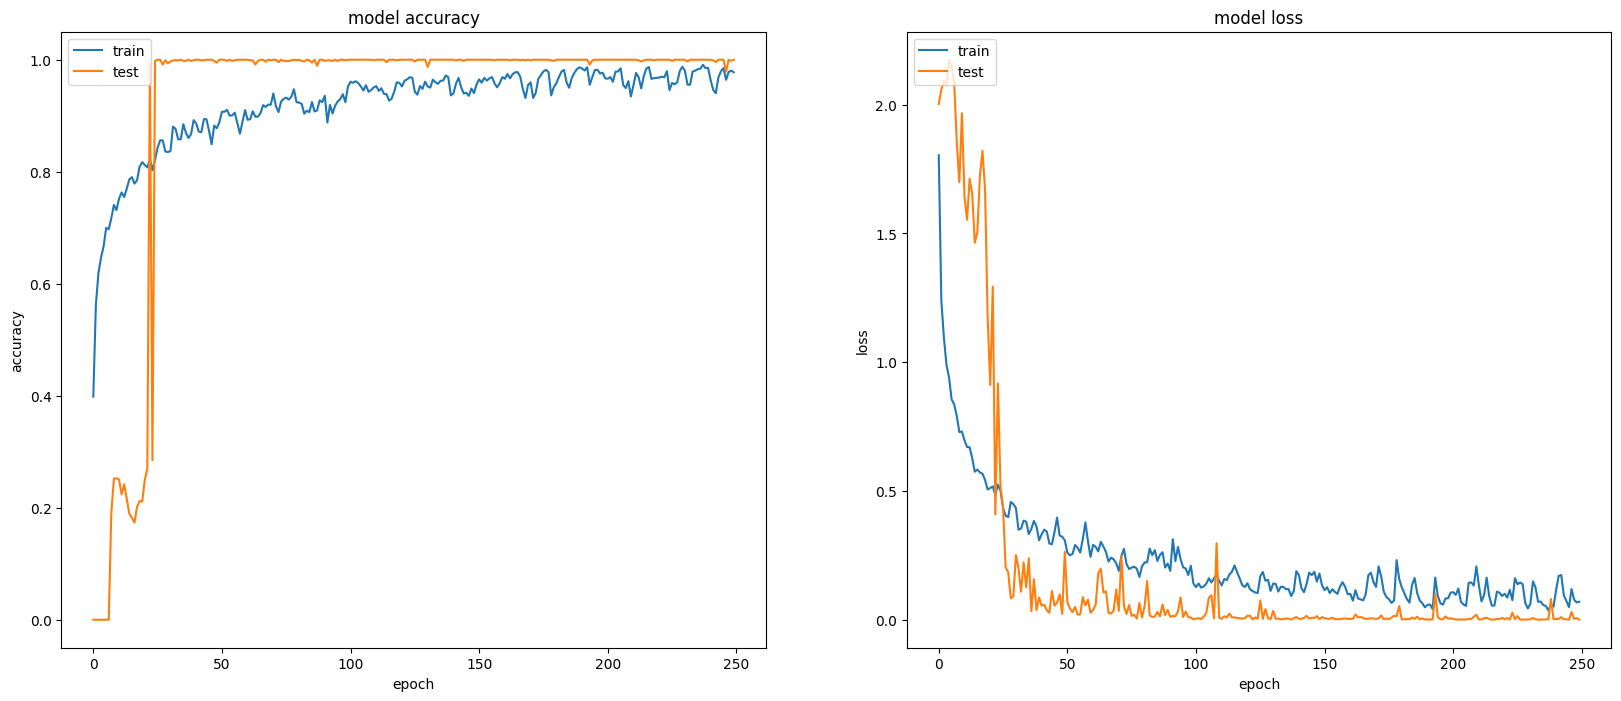

In [26]:
layers = [(1000,"relu"), (2000,"relu"), (1000,"relu"), (2000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 1s 16ms/step - loss: 1.1733 - accuracy: 0.7194


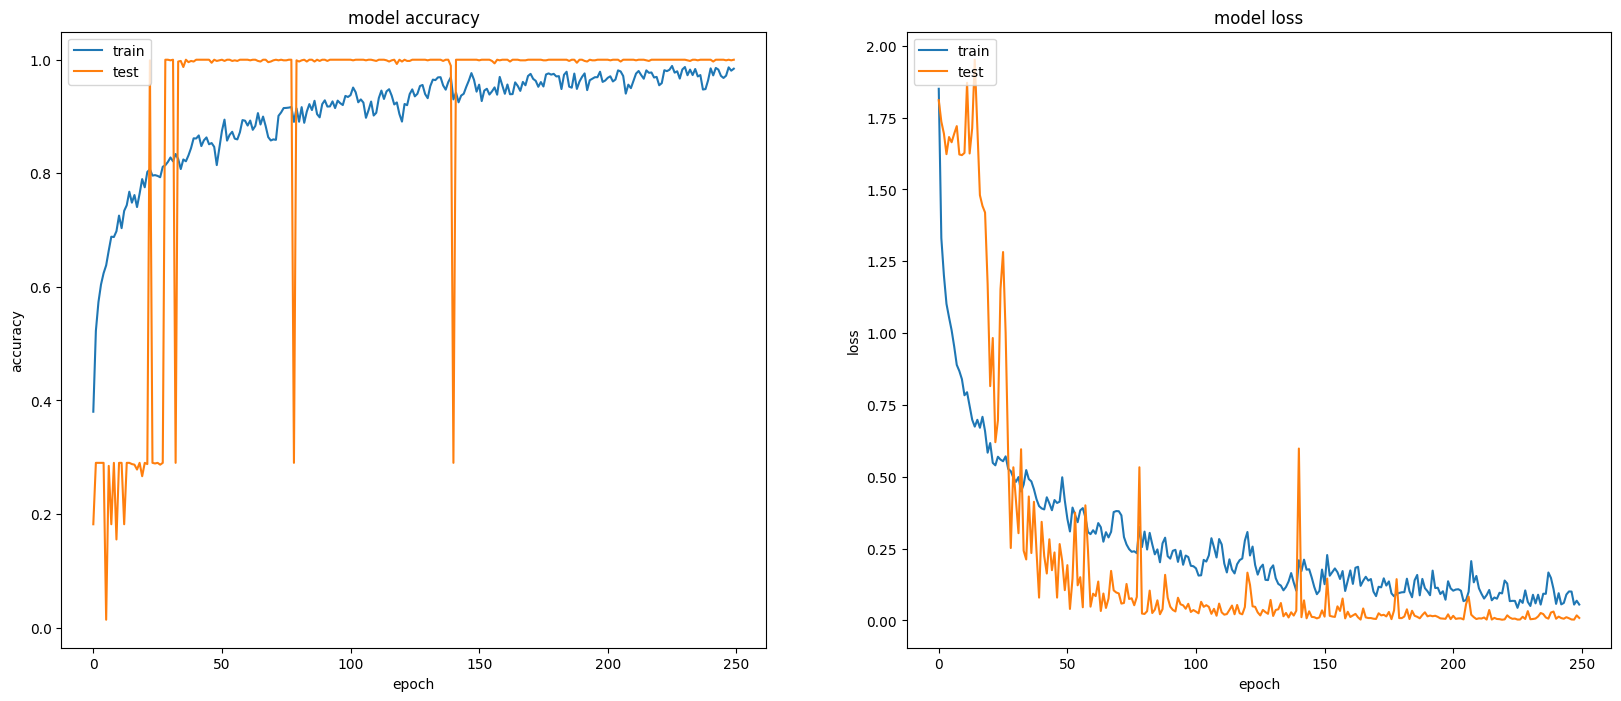

In [27]:
layers = [(5000,"relu"), (3000,"relu"), (1000,"relu"), (500,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 3ms/step - loss: 0.8934 - accuracy: 0.7827


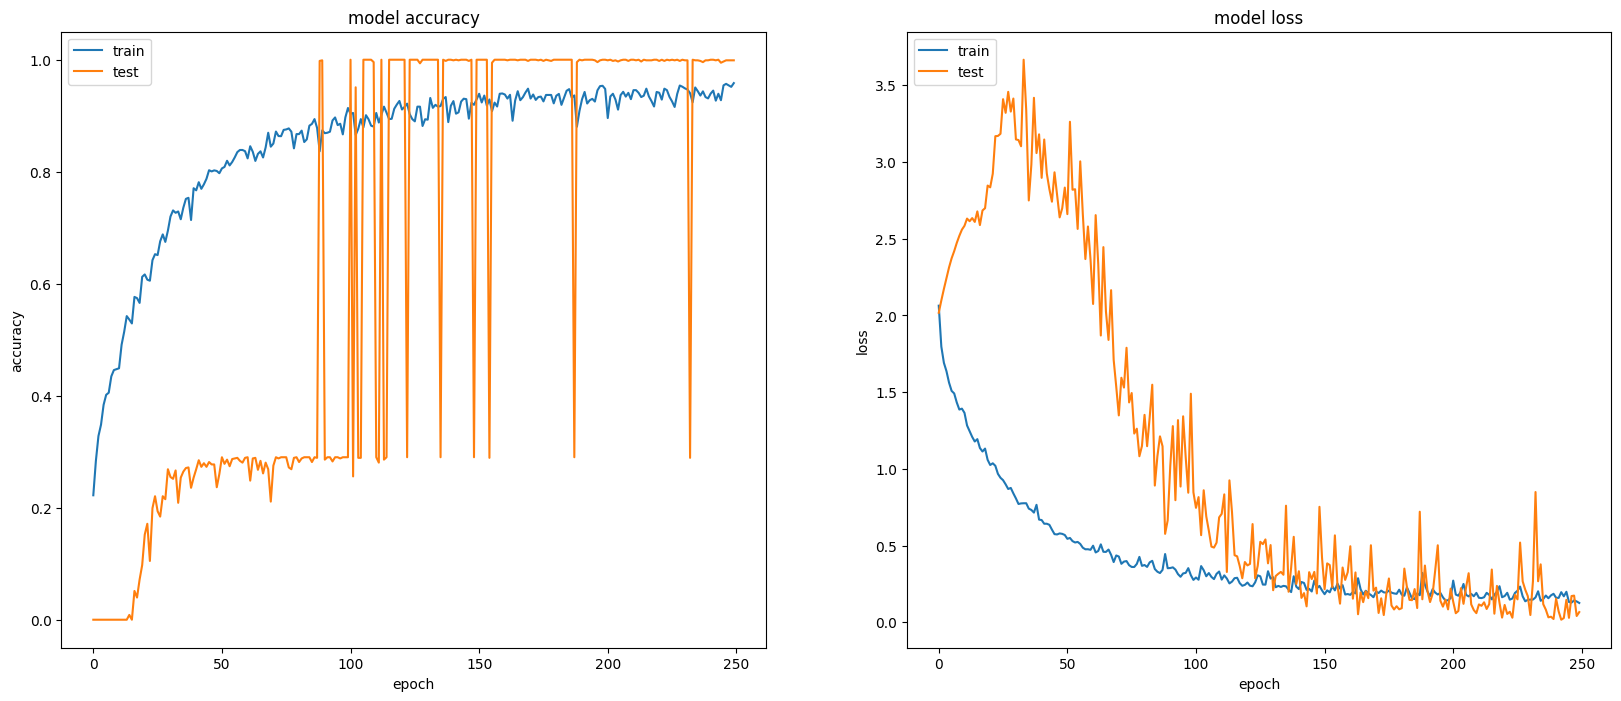

In [28]:
layers = [(1000,"relu"), (2000,"tanh")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 8ms/step - loss: 0.9636 - accuracy: 0.7417


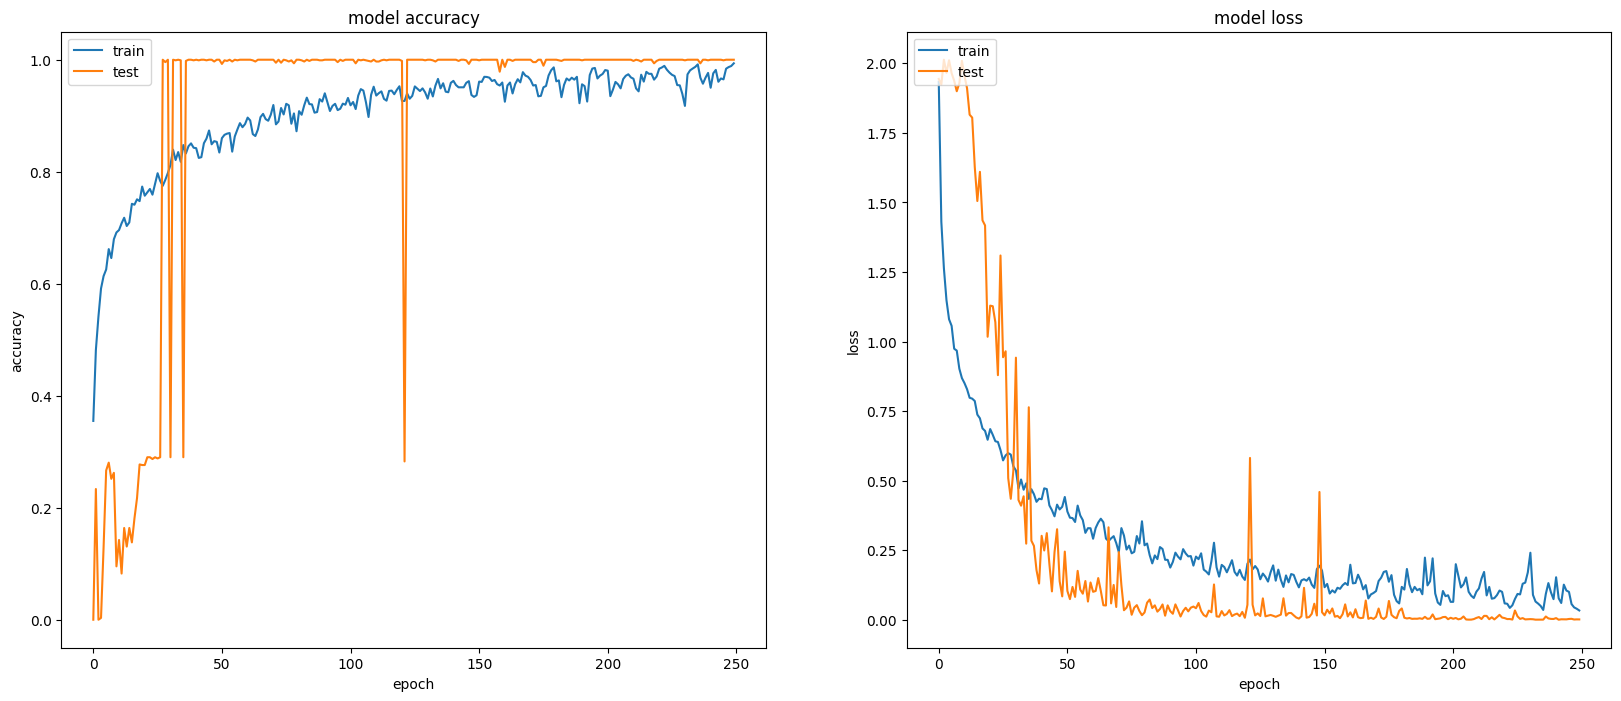

In [29]:
layers = [(1000,"relu"), (2000,"tanh"), (1000,"relu"), (2000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(5000,"relu"), (3000,"relu"), (1000,"tanh"), (500,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(1000,"relu"), (2000,"sigmoid")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(1000,"relu"), (2000,"sigmoid"), (1000,"relu"), (2000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(5000,"relu"), (3000,"relu"), (1000,"sigmoid"), (500,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

#### same layer like before with random fix dropout

In [ ]:
layers = [(1000,"relu"), (2000,"relu", 0.2)]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(1000,"relu"), (2000,"relu", 0.2), (1000,"relu",0.1), (2000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(5000,"relu"), (3000,"relu", 0.3), (1000,"relu", 0.25), (500,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(1000,"relu"), (2000,"tanh", 0.2)]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(1000,"relu"), (2000,"tanh", 0.2), (1000,"relu",0.1), (2000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(5000,"relu"), (3000,"relu", 0.3), (1000,"tanh", 0.25), (500,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(1000,"relu"), (2000,"sigmoid", 0.2)]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(1000,"relu"), (2000,"sigmoid", 0.2), (1000,"relu",0.1), (2000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
layers = [(5000,"relu"), (3000,"relu", 0.3), (1000,"sigmoid", 0.25), (500,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [ ]:
models

In [ ]:
def get_best_acc_model(models):
    bestItem = max(models, key=lambda x:x['best_accuracy'])
    return bestItem
def get_best_loss_model(models):
    bestItem = min(models, key=lambda x:x['best_loss'])
    return bestItem

## Get the best Model by loss

In [ ]:
best_model = get_best_loss_model(models)
best_model

## Get the best Model by accuracy

In [ ]:
best_model = get_best_acc_model(models)
models = []

best_model

### Change the batchSize for the best model - one lower, one higher

In [ ]:
layers = best_model['layers'] ## best model from step before
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

In [ ]:
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, batchSize=8, withHistory=1)
plot_acc_loss(history)

In [ ]:
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, batchSize=512, withHistory=1)
plot_acc_loss(history)

### Create the best model again and find now the best optimizer for this model
We create everytime the model new for the performance. Otherwise we must save every model and this don´t like our computer.

In [ ]:
best_model = get_best_acc_model(models)
models = []

best_model

In [ ]:
layers = best_model['layers'] ## best model from step before
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

In [ ]:
#Model with Nadam optimizer
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer='nadam', endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

In [ ]:
#Model with SGD optimizer
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer='sgd', endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

In [ ]:
#Model with Adagrad optimizer
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer='adagrad', endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

### Change the learning rate for the best model

In [ ]:
best_model = get_best_acc_model(models)
models = []

best_model

In [ ]:
layers = best_model['layers'] ## best model from step before
learningRate=best_model['learningRate']*50
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=learningRate, batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

In [ ]:
learningRate=best_model['learningRate']*100
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

In [ ]:
learningRate=best_model['learningRate']/50
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

In [ ]:
learningRate=best_model['learningRate']/100
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

In [ ]:
best_model = get_best_acc_model(models)
best_model

In [ ]:
layers = best_model['layers']
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)

## Save the best model

In [ ]:
model.save('best_model')
model = 0

## Load the best model

In [ ]:
model = keras.models.load_model('best_model')

## Analyse the model

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def analyse_my_mode(model, history):
    model.summary()
    print("\n")
    predictions = model.predict(X_test_bal, verbose=0)
    y_pred = (predictions > 0.5)
    y_test_=y_test_bal.astype(int).tolist()
    print(confusion_matrix(y_test_, y_pred.argmax(axis=1)))
    print("\n")
    print(classification_report(y_true=y_test_,y_pred=y_pred.argmax(axis=1), target_names=y_labels,zero_division=0))
    print("\n")
    
    plot_acc_loss(history);

In [ ]:
analyse_my_mode(model, history)

The following graph shows the different loss curves. We see we are close but there is still room for improvement. 

<img src="https://cs231n.github.io/assets/nn3/learningrates.jpeg">
(Effect of Learning rate on Loss (Source: CS231n Convolutional Neural Networks for Visual Recognition))

##  Model test

Finally, we test our model a little bit. For this we create a function that randomly creates five different cube values. We also plot the first predictions of the test data to visualize the accuracy.

In [ ]:
def predict_result(dices, printResult=False):
    dices = normalize_for_keras(dices)
    
    _ = model.predict([[dices[0], dices[1], dices[2], dices[3], dices[4]]], verbose=0)
    
    if printResult:
        return _
    
    result = y_labels[np.argmax(_, axis=1)[0]]

    print(result)

In [ ]:
diceOne = np.random.randint(low=1, high=6)
diceTwo = np.random.randint(low=1, high=6)
diceThree = np.random.randint(low=1, high=6)
diceFour = np.random.randint(low=1, high=6)
diceFive = np.random.randint(low=1, high=6)

print(diceOne,diceTwo,diceThree,diceFour,diceFive)
predict_result([diceOne,diceTwo,diceThree,diceFour,diceFive])

In [ ]:
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(7), fontsize=10)
  plt.xticks(rotation=90)
  plt.yticks([])
  thisplot = plt.bar(y_labels, predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
i = 0
prediction = model.predict([[2,1,3,4,1]], verbose=0)
plot_value_array(i, prediction[i], [i]) #small-straight

In [ ]:
#Basic from: https://www.tensorflow.org/tutorials/keras/classification
def plot_bars(num_rows=5, num_cols=3):
    predictions = model.predict(X_test)
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 3*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, num_cols, i+1)
      plot_value_array(i, predictions[i], y_test_bal.reset_index(drop=True))
      if type(X_bal) is not np.ndarray:
          dices = np.array(X_test_before.reset_index(drop=True))[i]
      else:
          dices = np.array(X_test)[i].astype(int)
      title = str(dices[0]) + "," + str(dices[1]) + "," + str(dices[2]) + "," + str(dices[3]) + "," + str(dices[4])
      plt.title(title)
      plt.subplots_adjust(hspace=1.2)
    plt.show()

In [ ]:
plot_bars(3,3)

## Conclusion

The data set in general was very unbalanced and rather small. In our first experiments, we had only balanced the training data. This caused the loss curve to fluctuate a lot.

In our first tests, we found that the number of neurons has a strong influence on the accurancy. Therefore, for the following tests we always worked with a number of neurons in the range of a thousand. Furthermore, we noticed that the activation function "TanH" is not so well suited for our problem. "Sigmoid" was somewhat better. However, the "Relu" activation function was the best.

We found that adding a BatchNormalization layer after each activation layer can bring up to 10% Accurancy.

The best optimizers in our case were "Adam" and "Nadam". Of course this can vary from model to model. 

BatchSize and Epochs:
Increasing the number of epochs can improve the accuracy a bit but only up to a certain point. In addition, a high number of epochs requires a lot of time to train the model. The BatchSize should, according to different sources from the Internet always be a power of 2. From a too large BatchSize the accuracy falls and the model is not so robust.